In [1]:
import re
import unicodedata
import pandas as pd
import nltk

from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

# visualize

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Spam Data

- Load the spam data set.
- Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?
- Is there any overlap in the bigrams for the spam data and the ham data?
- Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [2]:
# Load the Spam data set

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    
    'A simple function to cleanup text data'
    
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [4]:
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']

labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [5]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [6]:
# seperate the data into seperate pieces 

ham_words = clean(' '.join(df[df.label == 'ham'].text))

spam_words = clean(' '.join(df[df.label == 'spam'].text))

all_words = clean(' '.join(df.text))

In [7]:
# transform into a pandas series

ham_freq = pd.Series(ham_words).value_counts()

spam_freq = pd.Series(spam_words).value_counts()

all_freq = pd.Series(all_words).value_counts()

ham_freq.head()

im      449
get     314
go      273
ok      272
dont    257
dtype: int64

In [8]:
# create a dataframe with all three columns showing frequency counts

word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


In [9]:
# sort values by all

word_counts.sort_values(by='all', ascending=False).head(10)

,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5
free,275,59,216
know,267,241,26


In [10]:
# look for any words that are uniquely spam or ham

pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])

,all,ham,spam
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0
awarded,38,0,38
18,43,0,43
guaranteed,50,0,50
tone,73,0,73


-------

## Create Bigrams

----------

In [11]:
# see what spam_words is currently

type(spam_words)

list

In [12]:
# convert spam words to one string

spam_words = ' '.join([str(elem) for elem in spam_words])

In [13]:
# check to see that it has been converted to a string
type(spam_words)

str

In [14]:
#use bigrams to split

bigrams = nltk.ngrams(spam_words.split(), 2)


top_20_spam_bigrams = pd.Series(bigrams).value_counts().head(20)

In [15]:
top_20_spam_bigrams

(please, call)          44
(customer, service)     27
(po, box)               24
(guaranteed, call)      23
(a1000, cash)           23
(prize, guaranteed)     22
(every, week)           19
(await, collection)     19
(send, stop)            19
(selected, receive)     19
(chance, win)           19
(urgent, mobile)        18
(land, line)            18
(claim, call)           17
(valid, 12hrs)          17
(sae, tc)               16
(call, 08000930705)     16
(account, statement)    16
(prize, claim)          16
(draw, show)            15
dtype: int64

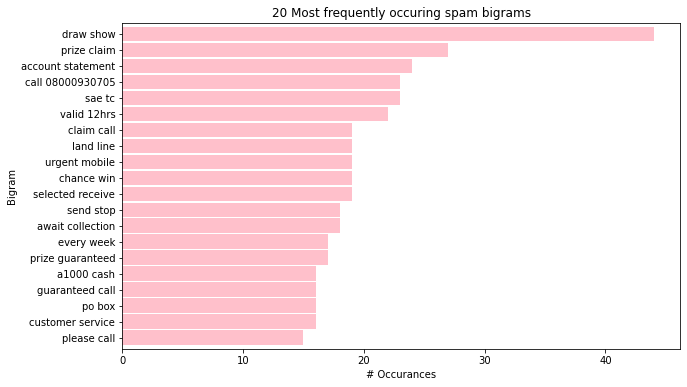

In [16]:
top_20_spam_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

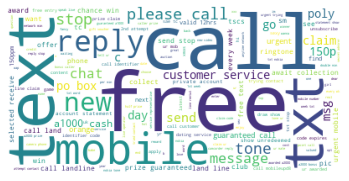

In [17]:
# spam words word cloud

from wordcloud import WordCloud



img = WordCloud(background_color='white').generate(spam_words)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.show()

----------------

In [18]:
# convert ham words to one string

ham_words = ' '.join([str(elem) for elem in ham_words])

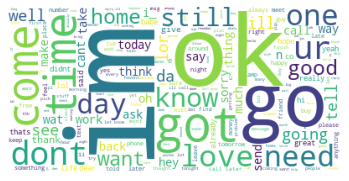

In [19]:
img = WordCloud(background_color='white').generate(ham_words)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.show()

In [20]:
#use bigrams to split ham words

bigrams = nltk.ngrams(ham_words.split(), 2)


top_20_ham_bigrams = pd.Series(bigrams).value_counts().head(20)

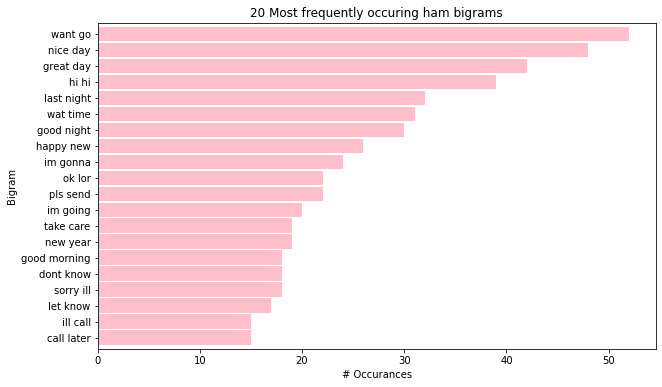

In [21]:
top_20_ham_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

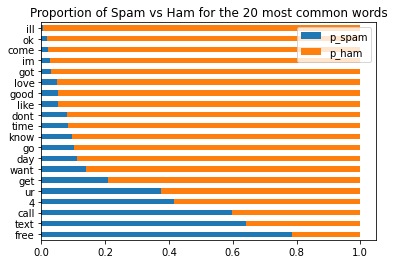

In [22]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')

Most spam messages will use words revolving around urgency, prizes, and money while ham messages will have verbage revolving around more natural conversation and asking how things are or things went

---------

### Trigrams

__________

In [23]:
trigrams_spam = nltk.ngrams(spam_words.split(), 3)

In [24]:
trigrams_ham = nltk.ngrams(ham_words.split(), 3)

In [25]:
top_20_spam_trigrams = pd.Series(trigrams_spam).value_counts().head(20)

In [26]:
top_20_ham_trigrams = pd.Series(trigrams_ham).value_counts().head(20)

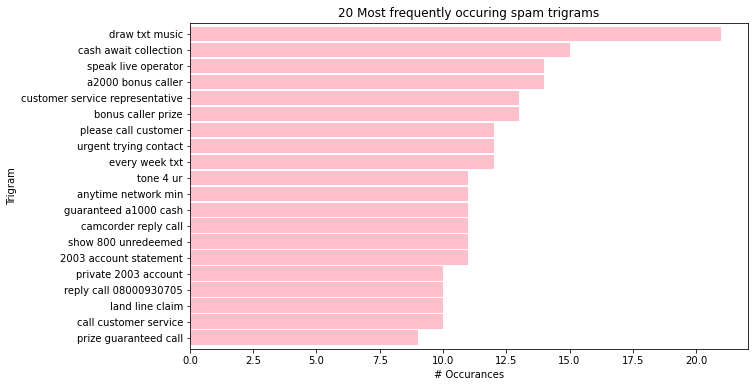

In [27]:
top_20_spam_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

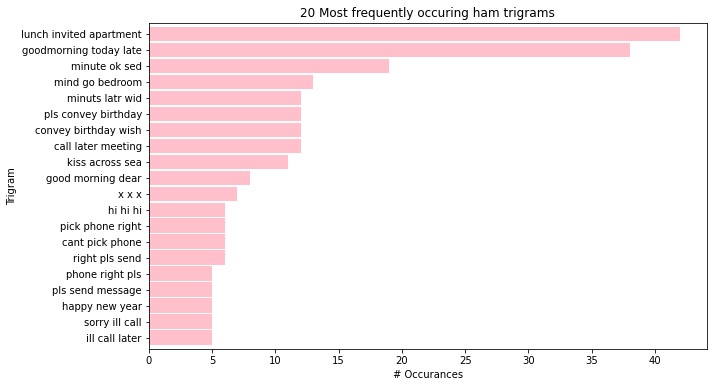

In [28]:
top_20_ham_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

-------------------

### Explore the news articles using the techniques discussed in the exploration lesson.

------------------

In [29]:
# import libraries


import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import bs4


import acquire_ryan

In [30]:
# define categories
categories = ["business", "sports"]

# use get_all_new_article function from acquire.py file 

news_df = acquire_ryan.get_all_news_articles(categories)

/Users/davidberchelmann/codeup-data-science/natural-language-processing-exercises/acquire_ryan.py:129: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 129 of the file /Users/davidberchelmann/codeup-data-science/natural-language-processing-exercises/acquire_ryan.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(response.text)


In [31]:
news_df.head()

,title,content,category
0,"RBI's ₹50,000 cr liquidity support a welcome m...",Apollo Hospitals Group Joint MD Dr Sangita Red...,business
1,2nd COVID-19 wave has impacted India's nascent...,Finance Minister Nirmala Sitharaman said that ...,business
2,Nandan Nilekani to help revamp COVID-19 bed al...,Infosys Co-founder Nandan Nilekani has extende...,business
3,Have faith in India's ability to come out of C...,RBI Governor Shaktikanta Das said that he has ...,business
4,"Citi pledges additional ₹200 cr aid for India,...",Citigroup has said it'll spend an additional ₹...,business


In [32]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt', '\n', 'ha']

def clean(content):
    
    'A simple function to cleanup text data'
    
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    content = (unicodedata.normalize('NFKD', content)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', content).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [33]:
labels = pd.concat([news_df.category.value_counts(),
                    news_df.category.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']

labels

,n,percent
sports,25,0.5
business,25,0.5


In [34]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(news_df, "category")

,n,percent
sports,25,0.5
business,25,0.5


In [35]:
# seperate the data into seperate pieces 

biz_words = clean(' '.join(news_df[news_df.category == 'business'].content))

sports_words = clean(' '.join(news_df[news_df.category == 'sports'].content))

all_words = clean(' '.join(news_df.content))

In [36]:
biz_freq = pd.Series(biz_words).value_counts()
sports_freq = pd.Series(sports_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [39]:
word_counts = (pd.concat([all_freq, biz_freq, sports_freq], axis=1, sort=True)
                .set_axis(['all', 'biz', 'sports'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.tail()

,all,biz,sports
yet,1,0,1
yogi,1,0,1
york,1,1,0
youngest,2,1,1
youve,1,0,1


In [40]:
pd.concat([word_counts[word_counts.biz == 0].sort_values(by='biz').tail(6),
           word_counts[word_counts.sports == 0].sort_values(by='sports').tail(6)])

,all,biz,sports
family,4,0,4
face,3,0,3
express,1,0,1
exemption,1,0,1
flight,1,0,1
youve,1,0,1
decline,2,2,0
decided,1,1,0
debut,2,2,0
david,1,1,0


Text(0.5, 1.0, 'Proportion of Business vs Sports for the 20 most common words')

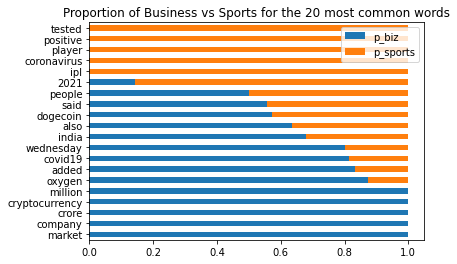

In [41]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_biz=word_counts.biz / word_counts['all'],
         p_sports=word_counts.sports / word_counts['all'])
 .sort_values(by='all')
 [['p_biz', 'p_sports']]
 .tail(20)
 .sort_values('p_sports')
 .plot.barh(stacked=True))

plt.title('Proportion of Business vs Sports for the 20 most common words')

In [42]:
# convert biz words to one string

biz_words = ' '.join([str(elem) for elem in biz_words])

In [43]:
# convert sports words to one string

sports_words = ' '.join([str(elem) for elem in sports_words])

In [44]:
#use bigrams to split ham words

bigrams_biz = nltk.ngrams(biz_words.split(), 2)
bigrams_sports = nltk.ngrams(sports_words.split(), 2)

top_20_biz_bigrams = pd.Series(bigrams_biz).value_counts().head(20)
top_20_sports_bigrams = pd.Series(bigrams_sports).value_counts().head(20)

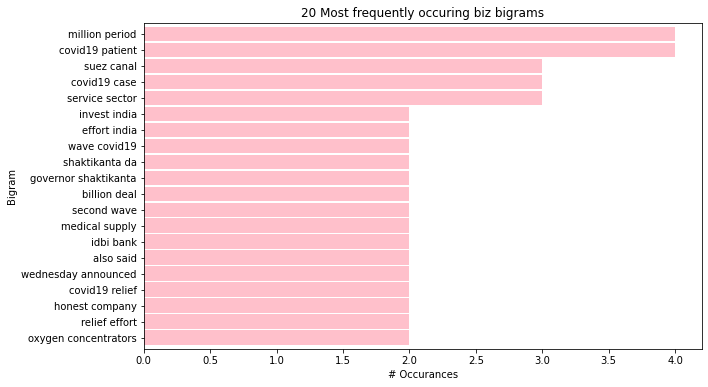

In [45]:
top_20_biz_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring biz bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_biz_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

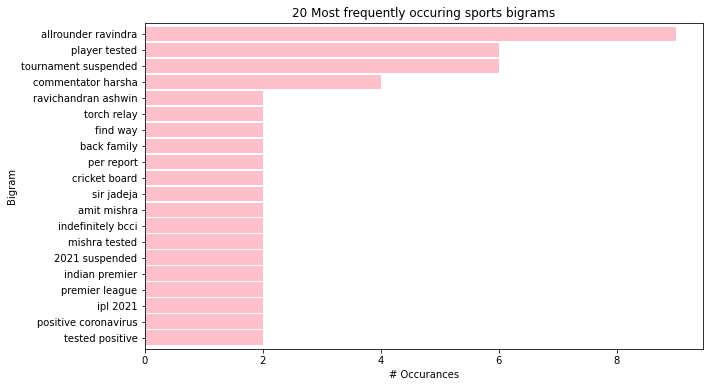

In [46]:
top_20_sports_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring sports bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_sports_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)